> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**> 

## Multivariate Input ,Univariate Output CNN ,Multi-Step
TThis tutorial is to demonstrate the process in build CNN for Multivariate Input, Univariate Output  for Multi Step. It consists of 2 major part which are :

The Demostration of Building CNN using Synthetic data and Exercise of building CNN using Daily_Demand_Forecasting_Order data. First, we will show the step in building the CNN :

Step 1. Data Preparation (Data Splitting,Data Sequencing,Data Standardization and Batching the Data) <br>
Step 2. Model Configuration for CNN<br>
Step 3. Train the model<br>
Step 4. Validate the model using graph<br>
Step 5. Evaluation Metrics such as MSE<br>
Step 6. Plot the forecast result<br>

First , let's us import the package needed

In [1]:
# import packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import math

In [2]:
# Function needed

# Data Sequencing Function
def multivariate_univariate_multi_step(sequence,window_size,n_multistep):
    x, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + window_size
        out_ix = end_ix + n_multistep -1
        # check if we are beyond the sequence
        if out_ix > len(sequence):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix,:-1], sequence[end_ix-1:out_ix,-1]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

# Training Function
def training(num_epochs, train_iter, test_iter, optimiser, loss_fn, model):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for t in range(num_epochs):
        # Initialise hidden state
        #     Don't do this if you want your LSTM to be stateful
        #     model.hidden = model.init_hidden()
        running_loss_train = 0
        running_loss_valid = 0
        for _, (train_X, train_Y) in enumerate(train_iter):
            # Forward pass
            y_train_pred = model(train_X)

            # Reshape to perform MSE
            y_train_pred = torch.reshape(y_train_pred, (train_Y.shape[0],train_Y.shape[1]))

            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimiser.step()

            running_loss_train += loss_train.item()

        epoch_loss_train = running_loss_train / len(train_X)
        train_loss[t] = epoch_loss_train

        with torch.no_grad():
            for _, (test_X, test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                # Reshape to perform MSE
                y_test_pred = torch.reshape(y_test_pred, (test_Y.shape[0], test_Y.shape[1]))
                loss_test = loss_fn(y_test_pred, test_Y)
                running_loss_valid += loss_test.item()

        epoch_loss_test = running_loss_valid / len(test_X)

        val_loss[t] = epoch_loss_test

    return train_loss, val_loss

## Hyperparameter

In [3]:
split_ratio = 0.70
num_epochs = 100
window_size = 4
n_step = 2
learning_rate = 0.01
# seed
torch.manual_seed(123)

## Data Preparation
We create synthetic data to make sure the model is created correctly and having ability to perform the forecasting

In [4]:
in_seq1 = np.array([x for x in range(0, 300, 10)])
in_seq2 = np.array([x for x in range(5, 305, 10)])
out_seq = np.array([in_seq1[i] + in_seq2[i] for i in range(len(in_seq1))])

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

## Data Splitting

In [5]:
split_data = round(len(dataset) * split_ratio)

# split data by indexing
train_data = dataset[:split_data]
test_data = dataset[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(21, 3)
test_data_shape
(9, 3)


## Data Standardization
Standardize your numeric attributes to have a 0 mean and unit variance.

In [6]:
# Build the standard scaler, Use to fit the train data and take the statistic of train data apply in test data
scaler = StandardScaler().fit(train_data.reshape(-1, 1))
train_data_standard = scaler.transform(train_data.reshape(-1, 1))
test_data_standard = scaler.transform(test_data.reshape(-1, 1))

In [7]:
# transform after scaling
train_data_standard  = train_data_standard.reshape(train_data.shape[0], train_data.shape[1])
print("test_data_standardlized" + str(train_data_standard .shape))

test_data_standard = test_data_standard.reshape(test_data.shape[0], test_data.shape[1])
print("test_data_standardlized" + str(test_data_standard.shape))

test_data_standardlized(21, 3)
test_data_standardlized(9, 3)


## Data Sequencing
Sequencing the data

In [8]:
trainX, trainY = multivariate_univariate_multi_step(train_data_standard, window_size,n_step)
testX, testY = multivariate_univariate_multi_step(test_data_standard, window_size,n_step)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

trainX shape:(17, 4, 2) trainY shape:(17, 2)

testX shape:(5, 4, 2) testY shape:(5, 2)


## Data Transform
Data need to transform from numpy to pytorch tensor before feed into the model then perform Data Transpose to make it can feed into CNN model

In [9]:
# make training and test sets in torch
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)

In [10]:
# 3D Data Preparation
trainX = torch.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
trainY = torch.reshape(trainY, (trainY.shape[0], n_step))
testX = torch.reshape(testX, (testX.shape[0], trainX.shape[1], trainX.shape[2]))
testY = torch.reshape(testY, (testY.shape[0], n_step))

## Data Transpose

In [11]:
# Data Transpose
trainX = torch.transpose(trainX, 1, 2)
testX = torch.transpose(testX, 1, 2)
print(f"after transpose trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"after transpose shape:{testX.shape} testY shape:{testY.shape}")

after transpose trainX shape:torch.Size([17, 2, 4]) trainY shape:torch.Size([17, 2])

after transpose shape:torch.Size([5, 2, 4]) testY shape:torch.Size([5, 2])


## Data Iterator
Iterator is create to allow the data separate into several batches to fasten the training process

In [12]:
# Create Iterator
train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset, batch_size=1, shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset, batch_size=1, shuffle=False)

## CNN Configuration
The method use to create the model is call pytorch subclass method. It consists of 2 part where the first part is allow user to define the structure of the model such as number of convolution layer , pooling layer and the linear layer

Second part of the method consist of forward() method , it allow user to control the flow of input data.For example , when the data pass in ,it will go throught the conv1 layer first then the output of conv1 layer will become the input for the ReLu activation function.The output of activation output will pass to the next pooling layer.

In [13]:
class CNN_Multivariate_Univariate(nn.Module):

    def __init__(self,timeseries,n_step):
        super(CNN_Multivariate_Univariate, self).__init__()
        
        self.timeseries = timeseries
        self.n_step = n_step
        
        # Conv1d1d kernel_size is base on the number of time series
        self.conv1 = nn.Conv1d(in_channels=timeseries, out_channels=64, kernel_size=2)
        
        # For example Input:(N,C,Lin) Output : (N,C,Lout)
        self.poo1 = nn.MaxPool1d(kernel_size=2)
    
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,n_step)

    def forward(self, x):
#         print("\n-------Convolution Block 1 ---------")
#         print(f"X shape {x.shape}")
        x=F.relu(self.conv1(x))
#         print(f"after conv1 {x.shape}")
        x = self.poo1(x)
#         print(f"after poo1 {x.shape}\n")
#         x = F.pad(x, (0, 1))
#         x = self.poo3(x)
#         print(f"after poo3 {x.shape}")
#         # Flatten the data ,x.view(-1,a) , where a = input for next linear layer input
# #         print(f"poo2 shape {x.shape}")
        x = x.view(-1,64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

## Input Model
The number of time series feed as the attribute for the model. The other attribute such as kernel_size need to configure in the network configuration itself cause some modification is needed when the number of layer increase.

In [14]:
# Input te attribute need by the model
model = CNN_Multivariate_Univariate(timeseries =trainX.shape[1],n_step = n_step)
# Examine the model configuration 
print(model.eval())
# Define the optimizer (Here we use SGD as our optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Define the loss function (Here we use MSE as the loss function)
loss_fn = nn.MSELoss()

CNN_Multivariate_Univariate(
  (conv1): Conv1d(2, 64, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)


In [15]:
#  Xavier Weight Initialize 
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data)

model.apply(weights_init)

CNN_Multivariate_Univariate(
  (conv1): Conv1d(2, 64, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)

## Training

In [16]:
# Start Training
train_loss, val_loss = training(num_epochs, train_iter, test_iter, optimizer, loss_fn, model)

## Evaluation
A learning curve loss is plotted to define how well the data is fitting the model

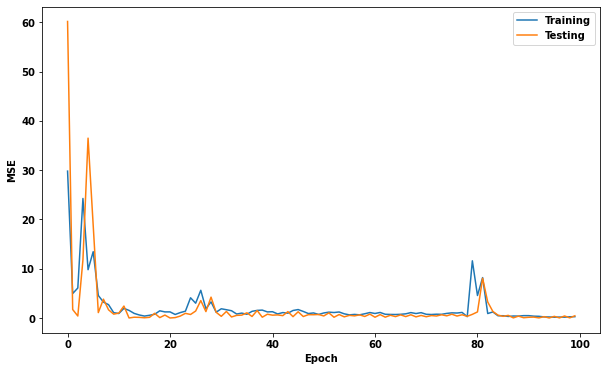

In [17]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Testing")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

## Inference
This section is to inference the model by feeding in testing data and determine the output forecast value and calculate the RMSE .

It consist of 4 section :

Section 1 : Feed in the train and test data to the model<br>
Section 2 : Reshape both train and test prediction back to the original data dimension<br>
Section 3 : Invert the scaling back to orignal data value<br>
Section 4 : Calculate the RMSE of train and test data

In [18]:
# Section 1 : make predictions
with torch.no_grad():
    y_train_prediction = model(trainX)
    y_test_prediction = model(testX)

In [19]:
# Section 2 : Reshape to original data
y_train_prediction = torch.reshape(y_train_prediction,(y_train_prediction.shape[0],y_train_prediction.shape[1]))
trainY = torch.reshape(trainY,(trainY.shape[0],trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction,(y_test_prediction.shape[0],y_test_prediction.shape[1]))
testY = torch.reshape(testY,(testY.shape[0],testY.shape[1]))

In [20]:
# Section 3 : Invert predictions
y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(trainY.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(testY.detach().numpy())

In [21]:
# Examine the test data and forecast result 
print("Test Data \t Forecast Result")
for i in range(len(y_test_prediction)):
    print(f"{y_test[i]}\t\t{y_test_prediction[i]}")

Test Data 	 Forecast Result
[485.      504.99997]		[509.65118 525.5356 ]
[504.99997 525.     ]		[533.0234  548.22314]
[525. 545.]		[556.3955  570.91077]
[545. 565.]		[579.78503 593.69684]
[565. 585.]		[603.1723 616.5604]


In [22]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 16.50 RMSE
Test Score: 31.77 RMSE


## Exercise for Multivariate (Solution)
Predict total number of demand of orders (Target Total Orders)
Data Source : https://code.datasciencedojo.com/datasciencedojo/datasets/tree/master/Daily%20Demand%20Forecasting%20Orders

In [23]:
demand = pd.read_csv(r"..\..\datasets\others\Daily_Demand_Forecasting_Orders.csv",sep=';')
demand.head()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In [24]:
demand.insert(1,"Day",range(1,len(demand)+1))
demand
demand.set_index('Day')

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
Day,,,,,,,,,,,,,
1,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
2,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
3,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
4,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
5,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517
6,2,4,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,47522,24966,207.364
7,2,5,144.124,118.919,43.304,66.371,153.368,0.000,46573,33597,48269,20973,263.043
8,2,6,119.379,113.870,38.584,85.961,124.413,15.709,35033,26278,56665,18502,248.958
9,3,2,218.856,124.381,33.973,148.274,162.044,1.054,66612,19461,103376,10458,344.291


In [25]:
demand_slice = demand.iloc[:,3::]
demand_slice.iloc[0:5,:]

,Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
2,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
3,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
4,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517


In [26]:
demand_value = demand_slice.values
demand_value.shape

(60, 11)

## Hyperparameter
Define the hyper parameter that need to tune the model

In [27]:
#Hyperameter
split_ratio_demand = 0.70
num_epochs_demand  = 1000
window_size_demand = 4
n_step_demand = 2
learning_rate_demand = 0.01
batch_size_demand = 10

#seed
torch.manual_seed(123)

## Data Splitting

In [28]:
split_data_demand = round(len(dataset)*split_ratio)
split_data_demand

21

In [29]:
#split data by indexing 
train_data_demand = demand_value[:-split_data_demand]
test_data_demand = demand_value[-split_data_demand:]
train_time = demand.index[:-split_data_demand]
test_time = demand.index[-split_data_demand:]
print("train_data_shape")
print(train_data_demand.shape)
print("test_data_shape")
print(test_data_demand.shape)

train_data_shape
(39, 11)
test_data_shape
(21, 11)


## Data Standardization
Standardize your numeric attributes to have a 0 mean and unit variance.

In [30]:
# Build the standard scaler, Use to fit the train data and take the statistic of train data apply in test data
scaler_demand = StandardScaler().fit(train_data_demand .reshape(-1, 1))
train_data_standard_demand = scaler_demand.transform(train_data_demand .reshape(-1, 1))
test_data_standard_demand = scaler_demand.transform(test_data_demand .reshape(-1, 1))

In [31]:
# Transform after scaling
train_data_standard_demand  = train_data_standard_demand .reshape(train_data_demand.shape[0],train_data_demand.shape[1])
print("train_data_normalized"+str(train_data_standard_demand.shape))

test_data_standard_demand = test_data_standard_demand.reshape(test_data_demand.shape[0],test_data_demand.shape[1])
print("test_data_normalized"+str(test_data_standard_demand.shape))

train_data_normalized(39, 11)
test_data_normalized(21, 11)


## Data Seqeuncing

In [32]:
# Data Seqeuncing

trainX_demand ,trainY_demand =  multivariate_univariate_multi_step(train_data_standard_demand ,window_size_demand,n_step_demand)
testX_demand , testY_demand = multivariate_univariate_multi_step(test_data_standard_demand.reshape(test_data_demand.shape[0],test_data_demand.shape[1])
,window_size_demand,n_step_demand)
print(f"trainX_demand shape:{trainX_demand.shape} trainY_demand shape:{trainY_demand.shape}\n")
print(f"testX_demand shape:{testX_demand.shape} testX_demand shape:{testY_demand.shape}")

trainX_demand shape:(35, 4, 10) trainY_demand shape:(35, 2)

testX_demand shape:(17, 4, 10) testX_demand shape:(17, 2)


## Data Transform

In [33]:
#  Data Transform

# make training and test sets in torch
trainX_demand = torch.from_numpy(trainX_demand).type(torch.Tensor)
trainY_demand = torch.from_numpy(trainY_demand).type(torch.Tensor)
testX_demand = torch.from_numpy(testX_demand).type(torch.Tensor)
testY_demand = torch.from_numpy(testY_demand).type(torch.Tensor)

#3D Data Preparation
trainX_demand = torch.reshape(trainX_demand,(trainX_demand.shape[0],trainX_demand.shape[1],trainX_demand.shape[2]))
trainY_demand = torch.reshape(trainY_demand,(trainY_demand.shape[0],n_step_demand))
testX_demand = torch.reshape(testX_demand,(testX_demand.shape[0],trainX_demand.shape[1],trainX_demand.shape[2]))
testY_demand = torch.reshape(testY_demand,(testY_demand.shape[0],n_step_demand))

In [34]:
print(f"trainX_demand shape : {trainX_demand.shape}")
print(f"trainY_demand shape : {trainY_demand.shape}")
print(f"testX_demand shape  : {testX_demand.shape}")
print(f"testY_demand_demand shape : {testY_demand.shape}")

trainX_demand shape : torch.Size([35, 4, 10])
trainY_demand shape : torch.Size([35, 2])
testX_demand shape  : torch.Size([17, 4, 10])
testY_demand_demand shape : torch.Size([17, 2])


## Data Transpose

In [51]:
# trnaspose to suit CNN model
# Input: (N, C, L_in) in Conv1D
trainX_demand = torch.transpose(trainX_demand,1, 2)
testX_demand = torch.transpose(testX_demand, 1, 2)
print(f"after transpose trainX shape:{trainX_demand.shape} trainY shape:{trainY_demand.shape}\n")
print(f"after transpose shape:{testX_demand.shape} testY shape:{testY_demand.shape}")

after transpose trainX shape:torch.Size([35, 4, 10]) trainY shape:torch.Size([35, 2])

after transpose shape:torch.Size([17, 4, 10]) testY shape:torch.Size([17, 2])


## Data Iterator
Iterator is create to allow the data separate into several batches to fasten the training process

In [36]:
# Create Iterator
train_dataset_demand = TensorDataset(trainX_demand, trainY_demand)
train_iter_demand = DataLoader(train_dataset_demand,batch_size=batch_size_demand,shuffle=False)

test_dataset_demand = TensorDataset(testX_demand, testY_demand)
test_iter_demand = DataLoader(test_dataset_demand,batch_size=batch_size_demand,shuffle=False)

In [37]:
model_demand = CNN_Multivariate_Univariate(timeseries =trainX_demand.shape[1],n_step = n_step)
print(model_demand.eval())
optimizer_demand = torch.optim.Adam(model_demand.parameters(), lr=learning_rate_demand)
loss_fn_demand = nn.MSELoss()

CNN_Multivariate_Univariate(
  (conv1): Conv1d(10, 64, kernel_size=(2,), stride=(1,))
  (poo1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)


## Input Model
The number of time series feed as the attribute for the model. The other attribute such as kernel_size need to configure in the network configuration itself cause some modification is needed when the number of layer increase.

In [38]:
train_loss_demand,val_loss_demand = training(num_epochs_demand,train_iter_demand,test_iter_demand,
                                           optimiser = optimizer_demand,
                                           loss_fn = loss_fn_demand,
                                            model=model_demand)

## Evaluation
A learning curve loss is plotted to define how well the data is fitting the model

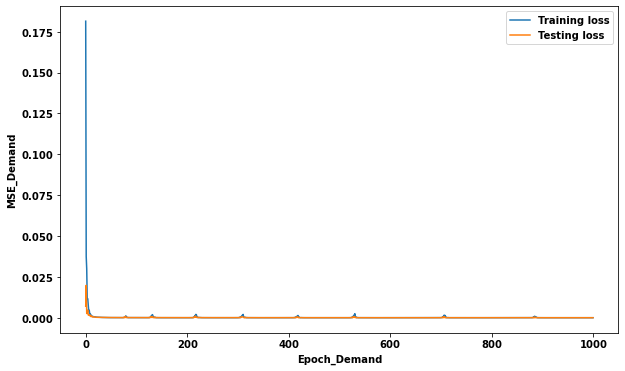

In [39]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_demand, label="Training loss")
plt.plot(val_loss_demand, label="Testing loss")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
plt.legend()
plt.show()

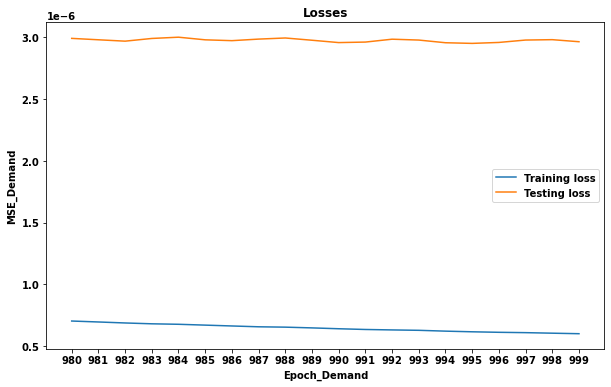

In [40]:
# Zoom in by fill in start_epoch and end_epoch
start_epoch = 980
end_epoch = 1000
plt.figure(figsize=(10,6))
plt.plot(train_loss_demand[start_epoch:end_epoch], label="Training loss")
plt.plot(val_loss_demand[start_epoch:end_epoch], label="Testing loss")
plt.title("Losses")
plt.xlabel("Epoch_Demand")
plt.ylabel("MSE_Demand")
position=range(end_epoch-start_epoch)
labels=range(start_epoch,end_epoch)
plt.xticks(position, labels)
plt.legend()
plt.show()

## Inference
This section is to inference the model by feeding in testing data and determine the output forecast value and calculate the RMSE .

It consist of 4 section :

Section 1 : Feed in the train and test data to the model<br>
Section 2 : Reshape both train and test prediction back to the original data dimension<br>
Section 3 : Invert the scaling back to orignal data value<br>
Section 4 : Calculate the RMSE of train and test data<br>

In [41]:
# Section 1 : make predictions 
with torch.no_grad():
    y_train_prediction_demand = model_demand(trainX_demand)
    y_test_prediction_demand = model_demand(testX_demand)

# Section 2 : Reshape to original data
y_train_prediction_demand = torch.reshape(y_train_prediction_demand,(y_train_prediction_demand.shape[0],y_train_prediction_demand.shape[1]))
trainY_demand = torch.reshape(trainY_demand,(trainY_demand.shape[0],trainY_demand.shape[1]))
y_test_prediction_demand = torch.reshape(y_test_prediction_demand,(y_test_prediction_demand.shape[0],y_test_prediction_demand.shape[1]))
testY_demand = torch.reshape(testY_demand,(testY_demand.shape[0],testY_demand.shape[1]))

In [42]:
# Section 3 : Invert predictions
y_train_prediction_demand = scaler_demand.inverse_transform(y_train_prediction_demand)
y_train_demand = scaler_demand.inverse_transform(trainY_demand)
y_test_prediction_demand = scaler_demand.inverse_transform(y_test_prediction_demand)
y_test_demand = scaler_demand.inverse_transform(testY_demand)

In [43]:
print("Test Data \t\t Forecast Result")
for i in range(len(y_test_prediction_demand)):
    print(f"{y_test_demand[i]}\t\t{y_test_prediction_demand[i]}")

y-test_demand				y-predict_demand
[234.50249 234.72319]		[44.88725 94.4517 ]
[234.72319 230.06499]		[290.2349  174.84038]
[230.06499 357.3931 ]		[264.2935  199.92827]
[357.3931  259.24466]		[456.29935 377.41458]
[259.24466 244.23491]		[378.79935 395.57278]
[244.23491 402.606  ]		[380.77982 317.87943]
[402.606   255.06108]		[327.84427 192.6978 ]
[255.06108 342.606  ]		[379.57864 258.92435]
[342.606  268.6392]		[458.9966  324.32278]
[268.6392  188.60014]		[269.13724 172.5767 ]
[188.60014 202.02202]		[156.15288 225.55717]
[202.02202 213.5103 ]		[337.64114 244.90483]
[213.5103  316.85013]		[412.2134  260.93216]
[316.85013 286.41068]		[462.6509  414.97122]
[286.41068 303.44583]		[257.41458 296.53568]
[303.44583 304.94974]		[384.49075 278.89505]
[304.94974 331.89896]		[509.7017  184.89702]


In [44]:
print(f"y_test_demand_shape : {y_test_demand.shape}")
print(f"y_test_demand_pred_shape : {y_test_prediction_demand.shape}")

y_test_demand_shape : (17, 2)
y_test_demand_pred_shape : (17, 2)


In [45]:
# calculate root mean squared error
trainScore_demand = math.sqrt(mean_squared_error(y_train_demand[:,0], y_train_prediction_demand[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_demand))
testScore_demand = math.sqrt(mean_squared_error(y_test_demand[:,0], y_test_prediction_demand[:,0]))
print('Test Score: %.2f RMSE' % (testScore_demand))

Train Score: 28.43 RMSE
Test Score: 120.56 RMSE


## Forecast Result

### Plot Explanation
- Blue Line-Indicate as test data before sequencing
- Green Line-Indicate as the testY data after sequencing
- Red Line-Indicate as the predicted testY data (Forecast) after sequencing

Window size = 4 , hence the time need start from +3 due to taking 3 data point as x-feature.

- **x-feature = window size -1**

[ time+3,time+4 ] - This is because n_step_demand = 2 .If n_step_demand = 3 ,[ time+3,time+4,time_5 ] is need

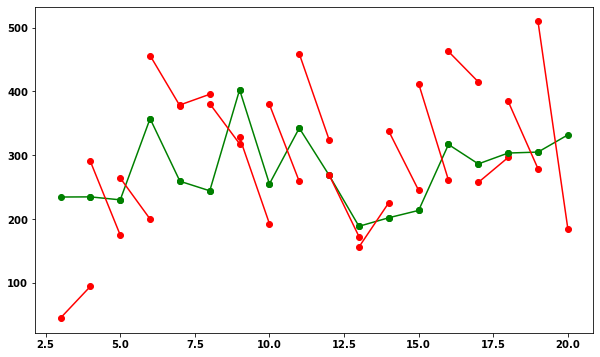

In [46]:
# Plot testY and predictionY data
plt.figure(figsize=(10,6))
for time in range(17):
        TestY_data=[y_test_demand[time][0],y_test_demand[time][1]]
        plt.plot([time+3,time+4],TestY_data,color="green",marker='o',label='TestY')
    
        textY_data=[y_test_prediction_demand[time][0],y_test_prediction_demand[time][1]]
        b = plt.plot([time+3,time+4], textY_data,color="red",marker='o',label='Forecast')

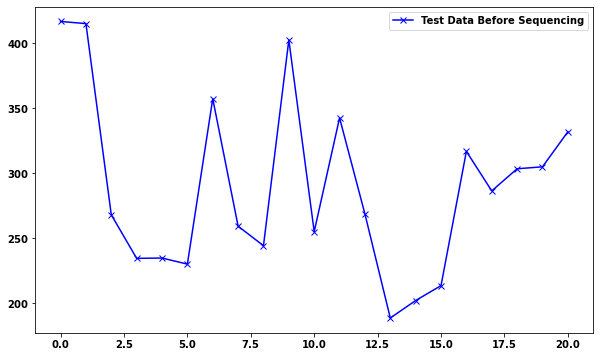

In [47]:
# Plot Original Test Data
plt.figure(figsize=(10,6))
plt.plot(test_data_demand[:,-1],marker='x',color="blue",label="Test Data Before Sequencing")
plt.legend()

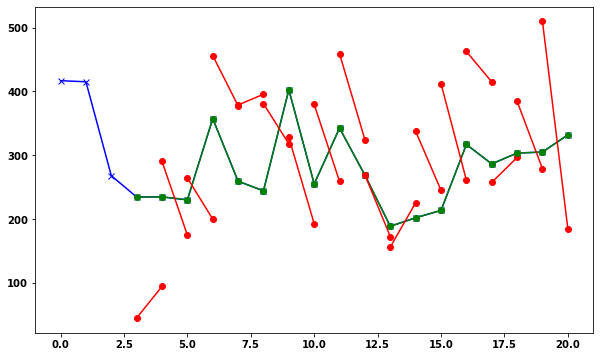

In [48]:

# Plot orginal test data , testY and predict testY after sequencing 
plt.figure(figsize=(10,6))
plt.plot(test_data_demand[:,-1],marker='x',color="blue",label="Test Data Before Sequencing")
for time in range(17):
        TestY_data=[y_test_demand[time][0],y_test_demand[time][1]]
        plt.plot([time+3,time+4],TestY_data,color="green",marker='o',label='TestY')
        
        textY_data=[y_test_prediction_demand[time][0],y_test_prediction_demand[time][1]]
        b = plt.plot([time+3,time+4], textY_data,color="red",marker='o',label='Forecast')

## Reference
1. Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee